In [1]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
train_dir='C:/Program Files/Pneumonia Detection using Deep Learning/model/chest_xray/train'
test_dir='C:/Program Files/Pneumonia Detection using Deep Learning/model/chest_xray/test'

In [3]:
batch_size = 1
epochs = 10
img_height = 224
img_width = 224

In [4]:
train_image_generator = ImageDataGenerator(rescale=1./255)  
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,directory=train_dir,shuffle=True,target_size=(img_height, img_width),class_mode='categorical')

Found 5232 images belonging to 2 classes.


In [5]:
val_image_generator = ImageDataGenerator(rescale=1./255)  
val_data_gen = val_image_generator .flow_from_directory(batch_size=batch_size,directory=test_dir,shuffle=True,target_size=(img_height, img_width),class_mode='categorical')

Found 624 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetB0

In [7]:
IMAGE_SIZE = [224, 224,3]

In [8]:
base_model = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

In [9]:
base_model.trainable = False

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
cnn_model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

In [12]:
cnn_model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [13]:
history = cnn_model.fit(train_data_gen, epochs=2,
validation_data= val_data_gen,)


Epoch 1/2
5232/5232 [==============================] - 2206s 421ms/step - loss: 0.1915 - accuracy: 0.9203 - val_loss: 0.3165 - val_accuracy: 0.8670
Epoch 2/2
5232/5232 [==============================] - 3468s 663ms/step - loss: 0.1259 - accuracy: 0.9511 - val_loss: 0.2071 - val_accuracy: 0.9135


In [14]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
def test_on_img(img):
    data=[]
    image = Image.open(img)
    image = image.resize((224,224))
    data.append(np.array(image))
    X_test=np.array(data)
    Y_pred = cnn_model.predict_classes(X_test)
    return image,Y_pred

In [15]:
import numpy as np

In [16]:
y=np.concatenate([val_data_gen.next()[1] for i in range(val_data_gen.__len__())])
true_labels=np.argmax(y, axis=-1)
prediction= cnn_model.predict(val_data_gen, verbose=2)
prediction=np.argmax(prediction, axis=-1)

624/624 - 223s - 223s/epoch - 358ms/step


In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
                          
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=true_labels, y_pred=prediction)

In [19]:
cm_plot_labels = ['Normal Lungs','Pneumonic Lungs']

Confusion matrix, without normalization
[[186  48]
 [  6 384]]
Accuracy: 0.913
Precision: 0.889
Recall: 0.913
F-Measure: 0.913


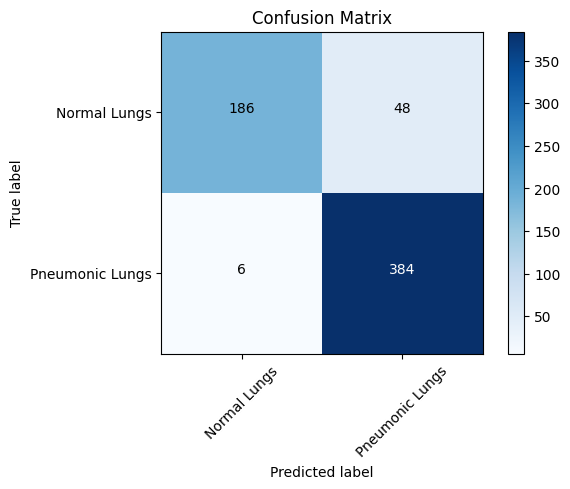

In [20]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
from sklearn.metrics import accuracy_score
acc=accuracy_score(true_labels,prediction) 
print('Accuracy: %.3f' % acc)
from sklearn.metrics import precision_score
precision = precision_score(true_labels,prediction,labels=[1,2], average='micro')
print('Precision: %.3f' % precision)
from sklearn.metrics import recall_score
recall = recall_score(true_labels,prediction, average='micro')
print('Recall: %.3f' % recall)
from sklearn.metrics import f1_score
score = f1_score(true_labels,prediction, average='micro')
print('F-Measure: %.3f' % score)

In [21]:
cnn_model.save('lung.h5')

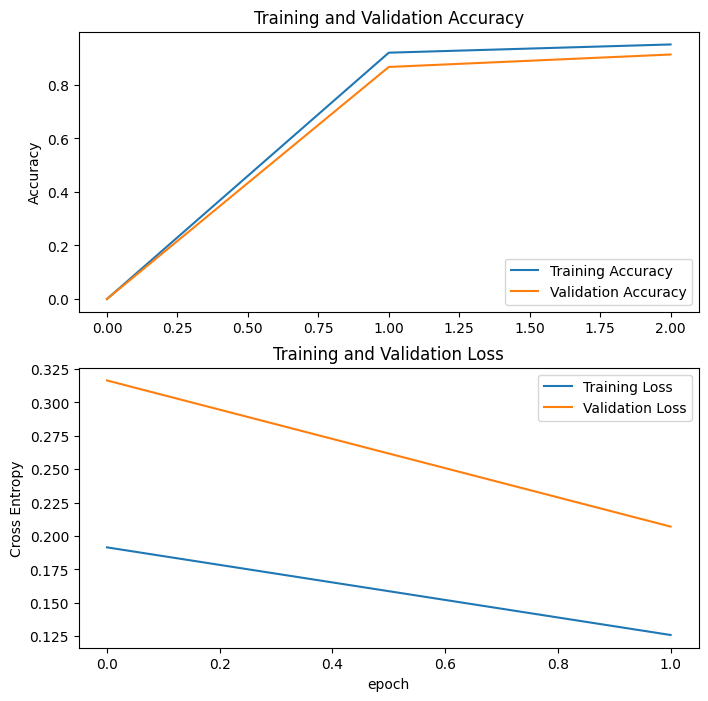

In [22]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()